In [1]:
# Importing necessary libraries

import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import random
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Flatten, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support





In [2]:
# Setting the directory path for the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'

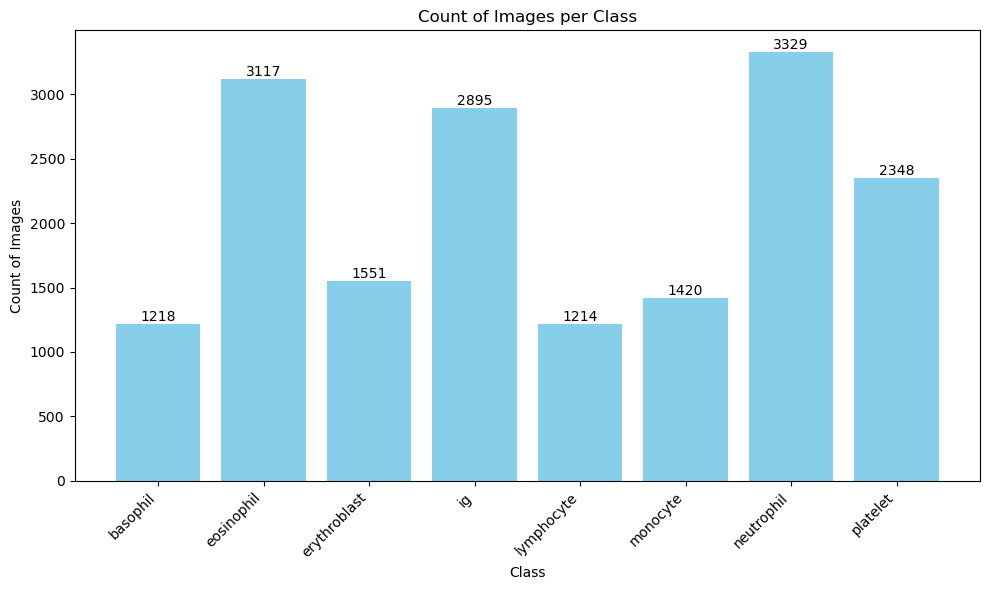

In [3]:
# Counting images per class
class_names = []
counts = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_files = len([filename for filename in os.listdir(class_dir)
                         if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
        class_names.append(class_name)
        counts.append(num_files)

# Displaying bar plot for counting images per class
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, color='skyblue')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', color='black')
plt.xlabel('Class')
plt.ylabel('Count of Images')
plt.title('Count of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('Count_of_images_per_class.png')
plt.show()

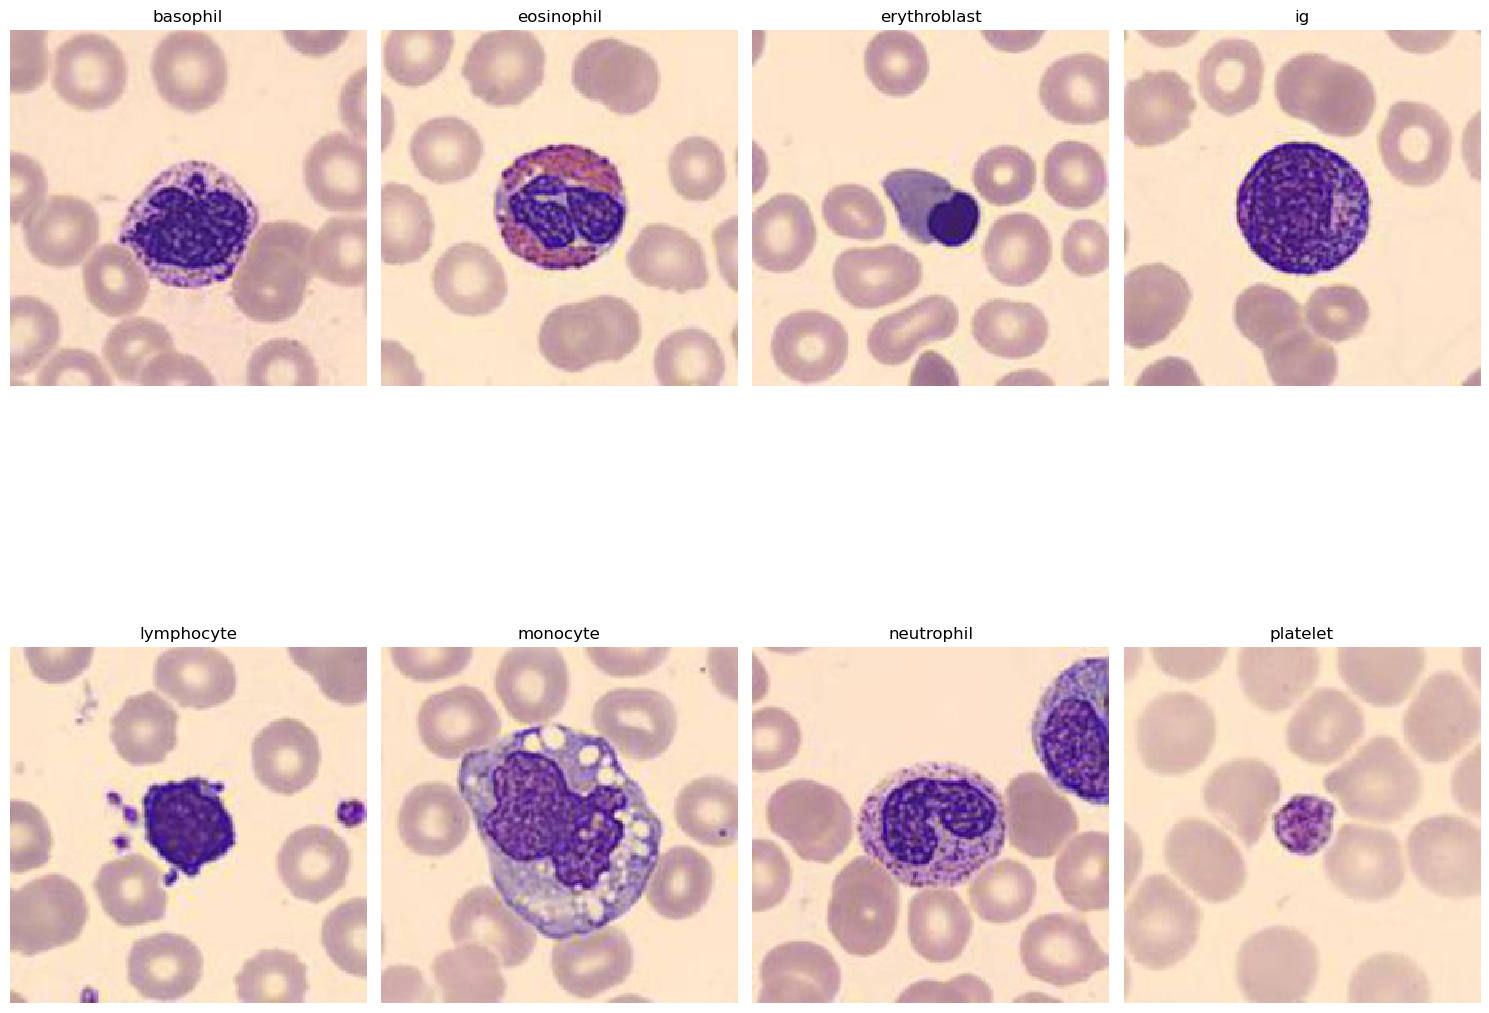

In [4]:
# Displaying random images per class
num_rows = 2
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
classes = os.listdir(dataset_path)
for i, class_name in enumerate(classes):
    row = i // num_cols
    col = i % num_cols
    class_path = os.path.join(dataset_path, class_name)
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    with Image.open(image_path) as img:
        axs[row, col].imshow(img, interpolation='nearest')
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')
plt.tight_layout()
#plt.savefig('image_per_class.png')
plt.show()

In [6]:
# Splitting the data into training and testing by stratified random sampling

# Initialize lists to store images and labels
images = []
labels = []

# Load images and labels
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = Image.open(image_path).resize((224, 224))
            images.append(np.array(image))
            labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Extract unique class names from labels
class_names = np.unique(labels)

# Perform stratified random split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels)


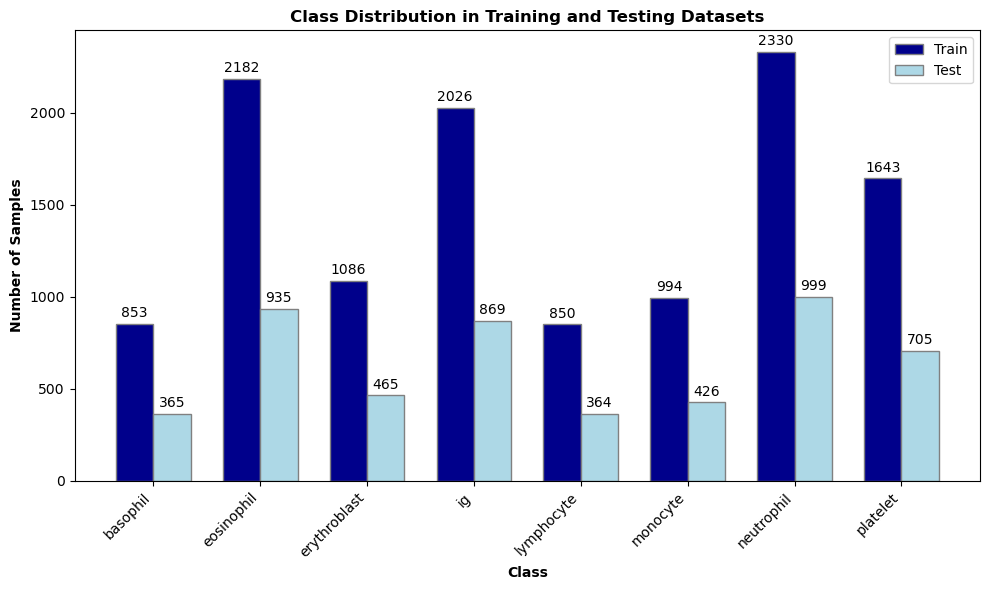

In [7]:
# Plotting the class distribution for both training and testing datasets
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
r1 = np.arange(len(train_classes))
r2 = [x + bar_width for x in r1]

ax.bar(r1, train_counts, color='darkblue', width=bar_width, edgecolor='grey', label='Train')
ax.bar(r2, test_counts, color='lightblue', width=bar_width, edgecolor='grey', label='Test')

for i, count in enumerate(train_counts):
    ax.text(r1[i], count + 20, str(count), ha='center', va='bottom')
for i, count in enumerate(test_counts):
    ax.text(r2[i], count + 20, str(count), ha='center', va='bottom')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Number of Samples', fontweight='bold')
ax.set_xticks([r + bar_width/2 for r in range(len(train_classes))])
ax.set_xticklabels(train_classes, rotation=45, ha='right')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Number of Samples', fontweight='bold')
ax.set_title('Class Distribution in Training and Testing Datasets', fontweight='bold')
ax.legend()

plt.tight_layout()
# Save the plot as an image file
#plt.savefig('plot_image.png')
plt.show()

In [8]:
# Modelling with CNN

# Define batch size
batch_size = 32

# Define the number of classes
num_classes = len(class_names)

# Define the CNN architecture using Sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Display model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,424 (91.20 MB)

 Trainable params: 23,908,424 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# model training
model.fit(X_train, y_train_encoded, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 179s 589ms/step - accuracy: 0.4484 - loss: 2.9223 - val_accuracy: 0.7656 - val_loss: 0.6525
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 176s 587ms/step - accuracy: 0.8085 - loss: 0.5563 - val_accuracy: 0.7597 - val_loss: 0.6589
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 175s 582ms/step - accuracy: 0.8517 - loss: 0.4090 - val_accuracy: 0.8554 - val_loss: 0.4334
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 175s 583ms/step - accuracy: 0.9005 - loss: 0.2886 - val_accuracy: 0.7593 - val_loss: 0.6260
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 177s 589ms/step - accuracy: 0.9100 - loss: 0.2447 - val_accuracy: 0.8629 - val_loss: 0.4013
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 176s 586ms/step - accuracy: 0.9362 - loss: 0.1873 - val_accuracy: 0.8872 - val_loss: 0.3433
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 176s 587ms/step - accuracy: 0.9577 - loss: 0.1233 - val_accuracy: 0.8842 - val_loss: 0.3619
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 174s 581ms/step - accuracy: 0.9547 -

In [10]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
#accuracy = accuracy_score(y_test_encoded, predicted_classes)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


# Calculate precision, recall, and F1-score
precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")


# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_encoded, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix.numpy())

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(confusion_matrix)
incorrect_counts = np.sum(confusion_matrix, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8679 - loss: 0.4372
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step
Test Accuracy: 0.8660296201705933
Test Loss: 0.46450233459472656
Precision: 0.884032041775249, Recall: 0.8660296411856474, F1-score: 0.8683688680397061
Confusion Matrix:
[[260   5   1  78  11  10   0   0]
 [  2 917   0  14   0   2   0   0]
 [  0   0 395  23  33   8   1   5]
 [  6   6   3 704  22 127   1   0]
 [  1   0   9  13 333   7   1   0]
 [  0   1   0  35   3 387   0   0]
 [  6  40   7 179   5   4 758   0]
 [  0   0  15   0   0   0   3 687]]
Class: basophil, Correct Predictions: 260, Incorrect Predictions: 105
Class: eosinophil, Correct Predictions: 917, Incorrect Predictions: 18
Class: erythroblast, Correct Predictions: 395, Incorrect Predictions: 70
Class: ig, Correct Predictions: 704, Incorrect Predictions: 165
Class: lymphocyte, Correct Predictions: 333, Incorrect Predictions: 31
Class: monocyte, Correct Predictions: 387, Incorrect Predictions: 39
Class: ne

161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step


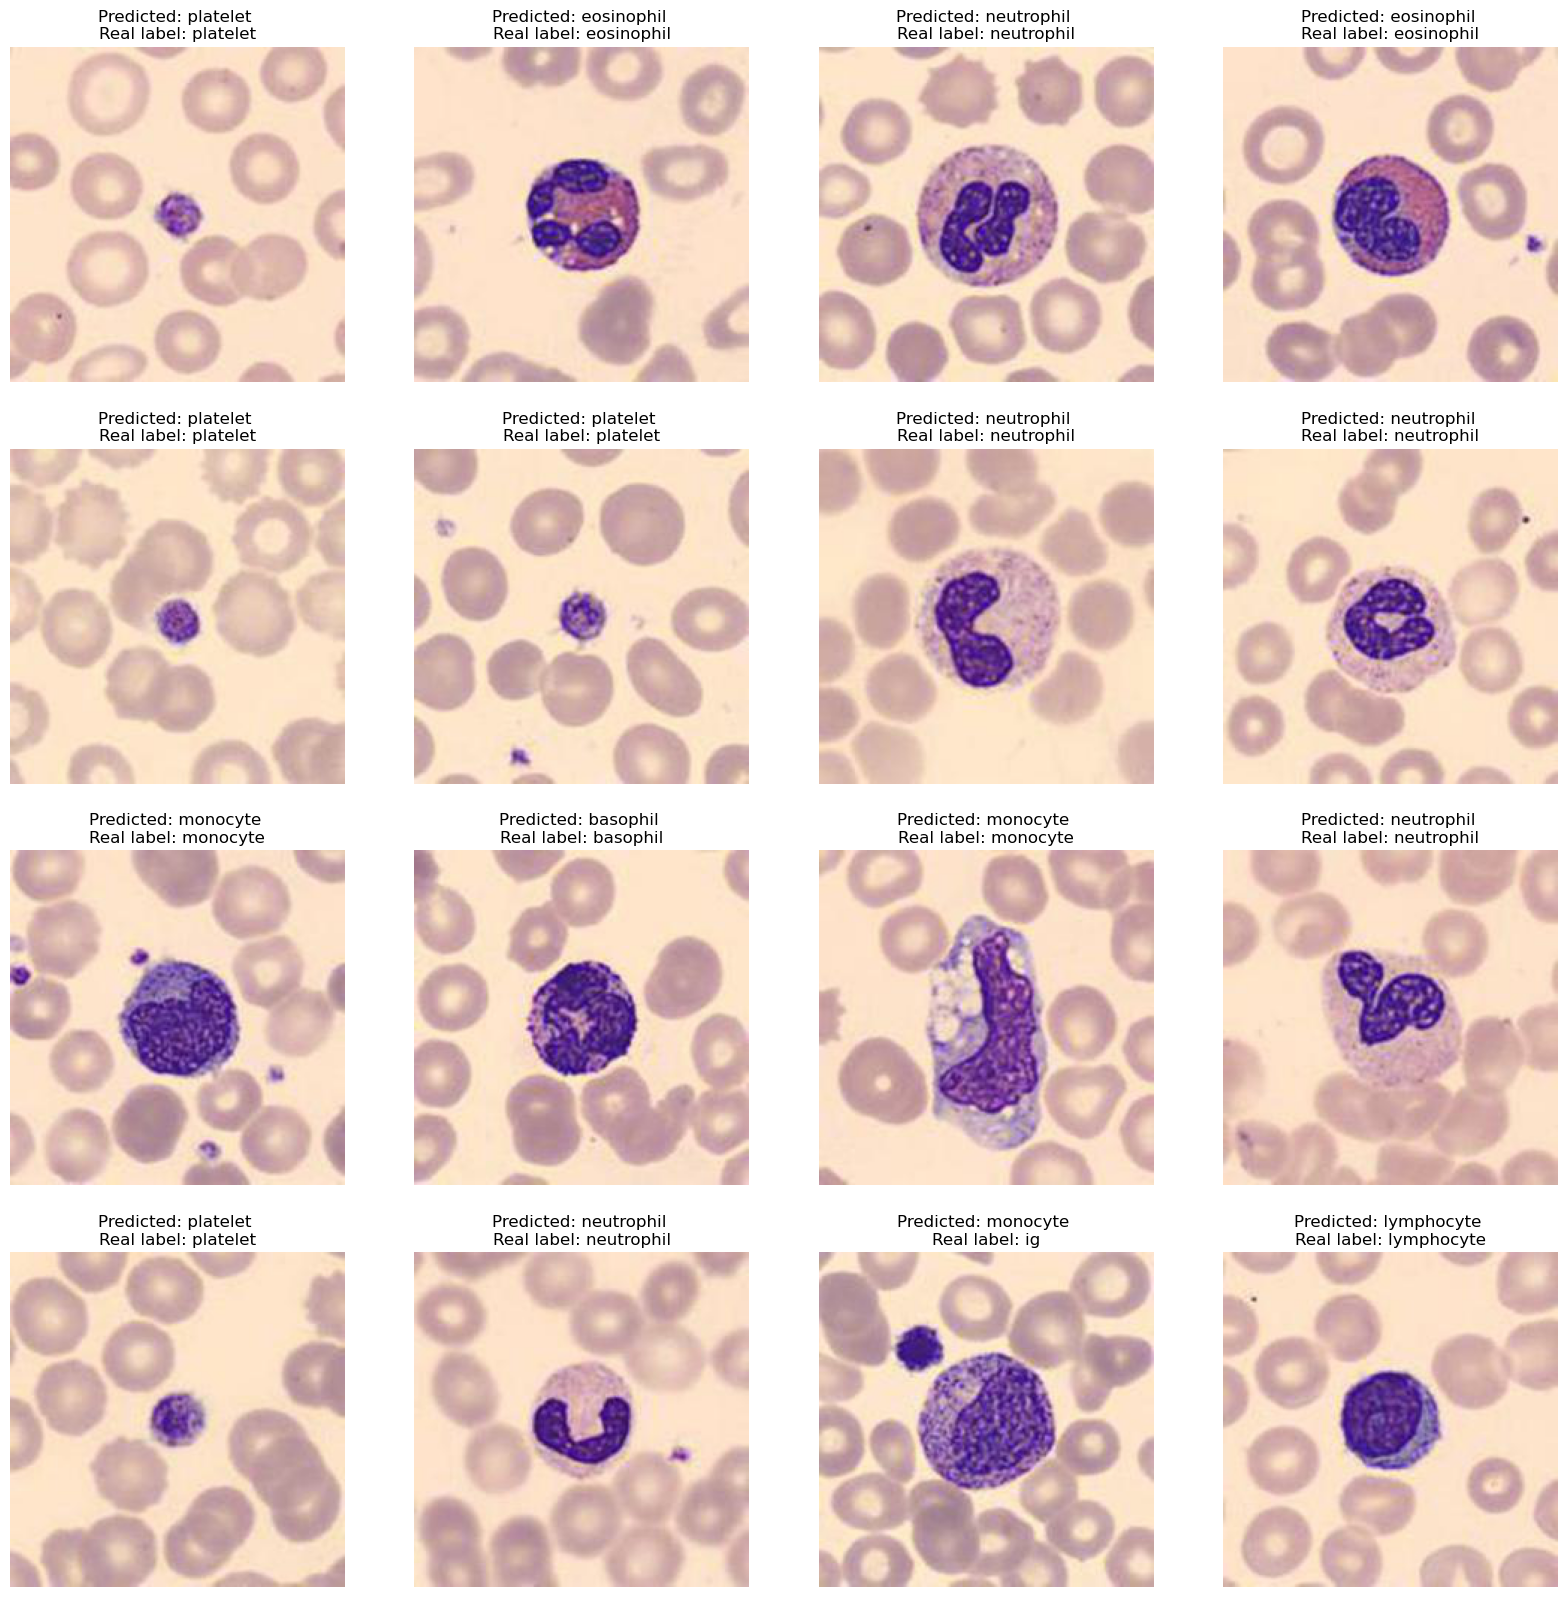

In [11]:
##Plotting the first 16 images predicted 
# Define the figure size
plt.figure(figsize=(20, 20))

# Generate predictions
predictions = model.predict(X_test)
predicted_indexes = np.argmax(predictions, axis=1)

# Loop through the first 16 images
for i in range(16):
    # Create a subplot
    ax = plt.subplot(4, 4, i + 1)

    # Show image
    plt.imshow(X_test[i].astype("uint8"))

    # Predicted class
    predicted_class = class_names[predicted_indexes[i]]

    # Real class
    real_class = class_names[y_test_encoded[i]]

    # Set title
    plt.title(f'Predicted: {predicted_class} \nReal label: {real_class}')

    # Turn off axis
    plt.axis("off")

# Show the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


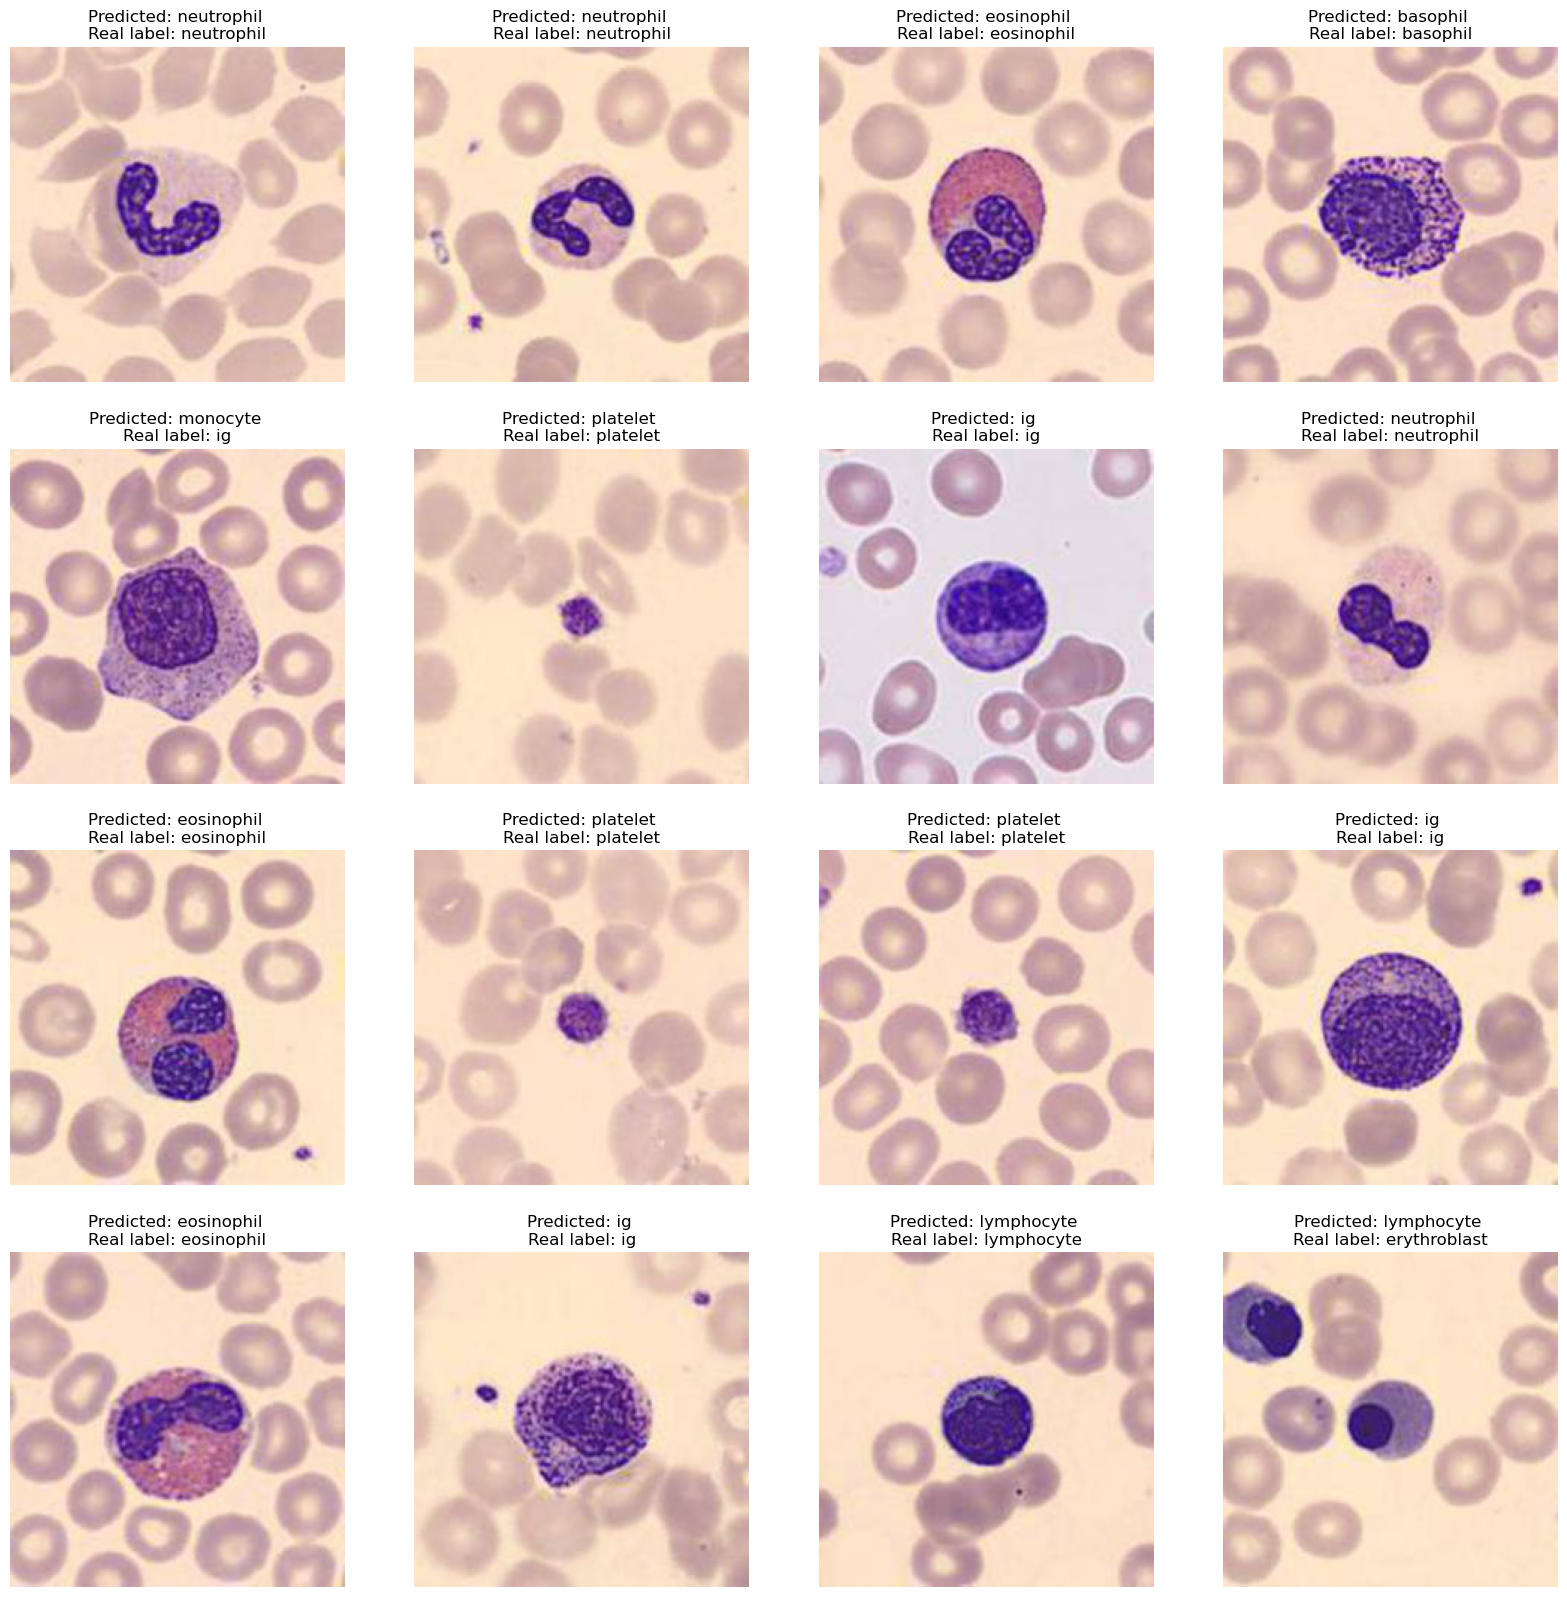

In [12]:
##Plotting 16 images predicted randomnly


# Define the figure size
plt.figure(figsize=(20, 20))

# Generate random indices for 16 images
random_indices = np.random.choice(len(X_test), size=16, replace=False)

# Generate predictions for the selected images
predictions = model.predict(X_test[random_indices])
predicted_indexes = np.argmax(predictions, axis=1)

# Loop through the selected images
for i, idx in enumerate(random_indices):
    # Create a subplot
    ax = plt.subplot(4, 4, i + 1)

    # Show image
    plt.imshow(X_test[idx].astype("uint8"))

    # Predicted class
    predicted_class = class_names[predicted_indexes[i]]

    # Real class
    real_class = class_names[y_test_encoded[idx]]

    # Set title
    plt.title(f'Predicted: {predicted_class} \nReal label: {real_class}')

    # Turn off axis
    plt.axis("off")

# Show the plot
plt.show()


In [13]:
### CNN Model while shuffling the Images

# Shuffle the data
random_state = 42  
indices = np.arange(len(labels))
np.random.seed(random_state)
np.random.shuffle(indices)
shuffled_images = images[indices]
shuffled_labels = labels[indices]

# Perform stratified train-test split with shuffled images
test_size = 0.3  
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(shuffled_images, shuffled_labels, test_size=test_size, stratify=shuffled_labels, random_state=random_state)

# Modeling with CNN with shuffled data

# Define the number of classes
num_classes = len(np.unique(labels))

# Define the CNN architecture using Sequential model
model_shuffled = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Display model summary
model_shuffled.summary()

# Compile the model
model_shuffled.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,424 (91.20 MB)

 Trainable params: 23,908,424 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels for training set
y_train_encoded_shuffled = label_encoder.fit_transform(y_train_shuffled)

# Train the model
model_shuffled.fit(X_train_shuffled, y_train_encoded_shuffled, batch_size=batch_size, epochs=10, validation_split=0.2)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 180s 589ms/step - accuracy: 0.4721 - loss: 2.3236 - val_accuracy: 0.6845 - val_loss: 0.8487
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 175s 582ms/step - accuracy: 0.7995 - loss: 0.5777 - val_accuracy: 0.8082 - val_loss: 0.5139
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 172s 575ms/step - accuracy: 0.8556 - loss: 0.4020 - val_accuracy: 0.8554 - val_loss: 0.4232
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 171s 569ms/step - accuracy: 0.8984 - loss: 0.2849 - val_accuracy: 0.8922 - val_loss: 0.3275
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 199s 559ms/step - accuracy: 0.9177 - loss: 0.2289 - val_accuracy: 0.9102 - val_loss: 0.2909
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 175s 584ms/step - accuracy: 0.9477 - loss: 0.1573 - val_accuracy: 0.8450 - val_loss: 0.4748
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 172s 573ms/step - accuracy: 0.9561 - loss: 0.1319 - val_accuracy: 0.8562 - val_loss: 0.4456
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 173s 576ms/step - accuracy: 0.9544 -

In [15]:
# Fit and transform labels for training set
y_test_encoded_shuffled = label_encoder.fit_transform(y_test_shuffled)

# Evaluate model on test set
test_loss, test_acc = model_shuffled.evaluate(X_test_shuffled, y_test_encoded_shuffled)

# Generate predictions for shuffled test set
predictions_shuffled = model_shuffled.predict(X_test_shuffled)
predicted_classes_shuffled = np.argmax(predictions_shuffled, axis=1)

# Calculate accuracy for shuffled test set
#accuracy_shuffled = accuracy_score(y_test_encoded_shuffled, predicted_classes_shuffled)
print(f"Test Accuracy (Shuffled): {test_acc}")
print(f"Test Loss (Shuffled): {test_loss}")

# Calculate precision, recall, and F1-score for shuffled test set
precision_shuffled = precision_score(y_test_encoded_shuffled, predicted_classes_shuffled, average='weighted')
recall_shuffled = recall_score(y_test_encoded_shuffled, predicted_classes_shuffled, average='weighted')
f1_shuffled = f1_score(y_test_encoded_shuffled, predicted_classes_shuffled, average='weighted')
print(f"Precision (Shuffled): {precision_shuffled}, Recall (Shuffled): {recall_shuffled}, F1-score (Shuffled): {f1_shuffled}")


# Calculate confusion matrix for shuffled test set
confusion_matrix_shuffled = tf.math.confusion_matrix(y_test_encoded_shuffled, predicted_classes_shuffled)

# Print confusion matrix for shuffled test set
print("Confusion Matrix (Shuffled):")
print(confusion_matrix_shuffled.numpy())

# Calculate counts of correct and incorrect predictions for each class in shuffled test set
correct_counts_shuffled = np.diag(confusion_matrix_shuffled)
incorrect_counts_shuffled = np.sum(confusion_matrix_shuffled, axis=1) - correct_counts_shuffled

# Print counts of correct and incorrect predictions for each class in shuffled test set
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}, Correct Predictions (Shuffled): {correct_counts_shuffled[i]}, Incorrect Predictions (Shuffled): {incorrect_counts_shuffled[i]}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.9036 - loss: 0.3296
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step
Test Accuracy (Shuffled): 0.9108814597129822
Test Loss (Shuffled): 0.30609357357025146
Precision (Shuffled): 0.9122427144230527, Recall (Shuffled): 0.9108814352574103, F1-score (Shuffled): 0.9102642014931615
Confusion Matrix (Shuffled):
[[306   4   2  44   2   0   7   0]
 [  0 913   1   3   0   0  16   2]
 [  1   0 379  16   5   1   8  55]
 [ 12   2  13 742  13  39  46   2]
 [  0   0  10  13 339   1   1   0]
 [  1   1   3  90   4 326   1   0]
 [  1   2  10  23   0   2 961   0]
 [  0   0   0   0   0   0   0 705]]
Class: basophil, Correct Predictions (Shuffled): 306, Incorrect Predictions (Shuffled): 59
Class: eosinophil, Correct Predictions (Shuffled): 913, Incorrect Predictions (Shuffled): 22
Class: erythroblast, Correct Predictions (Shuffled): 379, Incorrect Predictions (Shuffled): 86
Class: ig, Correct Predictions (Shuffled): 742, Incorrect Predictions (Shuffled):

In [3]:
# CNN - 5-fold Cross Validation - Achieved less accuracy and many incorrect predictions for platelets

# Function to load images and labels from the dataset directory
def load_dataset(dataset_path):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, filename)
                image = load_img(image_path, target_size=(224, 224))
                image = img_to_array(image)
                images.append(image)
                labels.append(class_name)
    return np.array(images), np.array(labels)

# Load images and labels from the dataset
images, labels = load_dataset(dataset_path)

# Define batch size
batch_size = 32

# Define the number of classes
class_names = np.unique(labels)
num_classes = len(class_names)

# Initialize StratifiedKFold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
all_test_loss = []
all_test_acc = []
all_test_precision = []
all_test_recall = []
all_test_f1 = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(images, labels), 1):
    print(f"Fold {fold}")

    # Split data into train and test sets for this fold
    X_train_cv, X_test_cv = images[train_index], images[test_index]
    y_train_cv, y_test_cv = labels[train_index], labels[test_index]

    # Initialize LabelEncoder
    label_encoder_cv = LabelEncoder()

    # Fit and transform labels for training set
    y_train_encoded_cv = label_encoder_cv.fit_transform(y_train_cv)

    # Define and compile the model for this fold
    model_cv = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])

    model_cv.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_encoded_cv, batch_size=batch_size, epochs=10, validation_split=0.2, verbose=0)

    # Evaluate the model on the test set for this fold
    y_pred_cv = model_cv.predict(X_test_cv)
    y_pred_classes_cv = np.argmax(y_pred_cv, axis=1)
    y_test_encoded_cv = label_encoder_cv.transform(y_test_cv)

    test_loss, test_acc = model_cv.evaluate(X_test_cv, y_test_encoded_cv, verbose=0)
    precision = precision_score(y_test_encoded_cv, y_pred_classes_cv, average='weighted')
    recall = recall_score(y_test_encoded_cv, y_pred_classes_cv, average='weighted')
    f1 = f1_score(y_test_encoded_cv, y_pred_classes_cv, average='weighted')

    print(f"Test Accuracy (Fold {fold}):", test_acc)
    print(f"Test Loss (Fold {fold}):", test_loss)
    print(f"Precision (Fold {fold}):", precision)
    print(f"Recall (Fold {fold}):", recall)
    print(f"F1 Score (Fold {fold}):", f1)

    # Calculate confusion matrix for this fold
    confusion_matrix_cv = tf.math.confusion_matrix(y_test_encoded_cv, y_pred_classes_cv)

    # Print confusion matrix for this fold
    print("Confusion Matrix (Fold {}):".format(fold))
    print(confusion_matrix_cv.numpy())

    # Calculate counts of correct and incorrect predictions for each class in this fold
    correct_counts_cv = np.diag(confusion_matrix_cv)
    incorrect_counts_cv = np.sum(confusion_matrix_cv, axis=1) - correct_counts_cv

    # Print counts of correct and incorrect predictions for each class in this fold
    for i, class_name in enumerate(class_names):
        print(f"Class: {class_name}, Correct Predictions (Fold {fold}): {correct_counts_cv[i]}, Incorrect Predictions (Fold {fold}): {incorrect_counts_cv[i]}")
    
    
    # Append evaluation metrics to lists
    all_test_loss.append(test_loss)
    all_test_acc.append(test_acc)
    all_test_precision.append(precision)
    all_test_recall.append(recall)
    all_test_f1.append(f1)

# Calculate and print average evaluation metrics across all folds
average_test_loss = sum(all_test_loss) / k_folds
average_test_acc = sum(all_test_acc) / k_folds
average_test_precision = sum(all_test_precision) / k_folds
average_test_recall = sum(all_test_recall) / k_folds
average_test_f1 = sum(all_test_f1) / k_folds

print("\nAverage Test Accuracy:", average_test_acc)
print("Average Test Loss:", average_test_loss)
print("Average Precision:", average_test_precision)
print("Average Recall:", average_test_recall)
print("Average F1 Score:", average_test_f1)


Fold 1
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step


C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy (Fold 1): 0.7642585635185242
Test Loss (Fold 1): 7.144199371337891
Precision (Fold 1): 0.721158234315434
Recall (Fold 1): 0.7642585551330798
F1 Score (Fold 1): 0.7299636531868189
Confusion Matrix (Fold 1):
[[184   3   0  46   8   1   2   0]
 [  1 597   1   4   0   0  20   0]
 [  0   1 287  10   8   2   3   0]
 [  5   2  29 467   9  35  32   0]
 [  0   0  10   2 227   3   0   0]
 [  0   1   4  59   2 215   3   0]
 [  1   3  10  15   0   1 636   0]
 [  0   1 466   0   0   0   3   0]]
Class: basophil, Correct Predictions (Fold 1): 184, Incorrect Predictions (Fold 1): 60
Class: eosinophil, Correct Predictions (Fold 1): 597, Incorrect Predictions (Fold 1): 26
Class: erythroblast, Correct Predictions (Fold 1): 287, Incorrect Predictions (Fold 1): 24
Class: ig, Correct Predictions (Fold 1): 467, Incorrect Predictions (Fold 1): 112
Class: lymphocyte, Correct Predictions (Fold 1): 227, Incorrect Predictions (Fold 1): 15
Class: monocyte, Correct Predictions (Fold 1): 215, Incorrect

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy (Fold 2): 0.7086867690086365
Test Loss (Fold 2): 3.968651294708252
Precision (Fold 2): 0.7014020056841335
Recall (Fold 2): 0.7086867505118456
F1 Score (Fold 2): 0.6750263360147606
Confusion Matrix (Fold 2):
[[185   4   6  24  15   9   1   0]
 [  0 591   3   2   3   0  24   0]
 [  2   2 291   2   5   1   7   0]
 [  2   3 106 256  44 141  27   0]
 [  0   1   3   0 232   7   0   0]
 [  0   0   6   8   7 262   1   0]
 [  1   1  47   3   2   6 606   0]
 [  0  12 453   0   2   0   3   0]]
Class: basophil, Correct Predictions (Fold 2): 185, Incorrect Predictions (Fold 2): 59
Class: eosinophil, Correct Predictions (Fold 2): 591, Incorrect Predictions (Fold 2): 32
Class: erythroblast, Correct Predictions (Fold 2): 291, Incorrect Predictions (Fold 2): 19
Class: ig, Correct Predictions (Fold 2): 256, Incorrect Predictions (Fold 2): 323
Class: lymphocyte, Correct Predictions (Fold 2): 232, Incorrect Predictions (Fold 2): 11
Class: monocyte, Correct Predictions (Fold 2): 262, Incorrec

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy (Fold 3): 0.7943241596221924
Test Loss (Fold 3): 5.7486748695373535
Precision (Fold 3): 0.7445415420704999
Recall (Fold 3): 0.7943241661790521
F1 Score (Fold 3): 0.7585767849830767
Confusion Matrix (Fold 3):
[[224   3   0  15   2   0   0   0]
 [  5 614   0   3   0   0   1   0]
 [  0   0 278  14  13   2   3   0]
 [  7   1   4 515   6  38   8   0]
 [  0   0   4   5 230   3   1   0]
 [  0   0   1  25   3 255   0   0]
 [  1   4   8  52   0   2 599   0]
 [  0   0 468   0   0   0   1   0]]
Class: basophil, Correct Predictions (Fold 3): 224, Incorrect Predictions (Fold 3): 20
Class: eosinophil, Correct Predictions (Fold 3): 614, Incorrect Predictions (Fold 3): 9
Class: erythroblast, Correct Predictions (Fold 3): 278, Incorrect Predictions (Fold 3): 32
Class: ig, Correct Predictions (Fold 3): 515, Incorrect Predictions (Fold 3): 64
Class: lymphocyte, Correct Predictions (Fold 3): 230, Incorrect Predictions (Fold 3): 13
Class: monocyte, Correct Predictions (Fold 3): 255, Incorrect

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy (Fold 4): 0.7633118629455566
Test Loss (Fold 4): 5.090123653411865
Precision (Fold 4): 0.710415444973783
Recall (Fold 4): 0.7633118782913985
F1 Score (Fold 4): 0.7267824649060007
Confusion Matrix (Fold 4):
[[220   2   0  19   0   2   0   0]
 [  1 617   0   4   0   0   2   0]
 [  0   2 256  22   8  10  12   0]
 [ 20   6   1 492   0  44  16   0]
 [  2   0   4  28 185  24   0   0]
 [  1   1   0  42   0 240   0   0]
 [  3  14   3  45   0   2 599   0]
 [  0   4 455   0   2   0   8   0]]
Class: basophil, Correct Predictions (Fold 4): 220, Incorrect Predictions (Fold 4): 23
Class: eosinophil, Correct Predictions (Fold 4): 617, Incorrect Predictions (Fold 4): 7
Class: erythroblast, Correct Predictions (Fold 4): 256, Incorrect Predictions (Fold 4): 54
Class: ig, Correct Predictions (Fold 4): 492, Incorrect Predictions (Fold 4): 87
Class: lymphocyte, Correct Predictions (Fold 4): 185, Incorrect Predictions (Fold 4): 58
Class: monocyte, Correct Predictions (Fold 4): 240, Incorrect P

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# 5-Fold Cross Validation for CNN with SMOTE()- 128x128-image size-batch size-16 due to memory constraints


# Function to load images and labels from the dataset directory
def load_dataset(dataset_path, target_size=(128, 128)):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, filename)
                image = load_img(image_path, target_size=target_size)
                image = img_to_array(image)
                images.append(image)
                labels.append(class_name)
    return np.array(images), np.array(labels)

# Load images and labels from the dataset
images, labels = load_dataset(dataset_path)

# Apply SMOTE to the entire training dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(images.reshape(images.shape[0], -1), labels)
X_resampled = X_resampled.reshape(-1, 128, 128, 3)

# Define batch size
batch_size = 16  # Reduced batch size

# Define the number of classes
class_names = np.unique(y_resampled)
num_classes = len(class_names)

# Initialize StratifiedKFold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
all_test_loss = []
all_test_acc = []
all_test_precision = []
all_test_recall = []
all_test_f1 = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X_resampled, y_resampled), 1):
    print(f"Fold {fold}")

    # Split data into train and test sets for this fold
    X_train_cv, X_test_cv = X_resampled[train_index], X_resampled[test_index]
    y_train_cv, y_test_cv = y_resampled[train_index], y_resampled[test_index]

    # Initialize LabelEncoder
    label_encoder_cv = LabelEncoder()

    # Fit and transform labels for training set
    y_train_encoded_cv = label_encoder_cv.fit_transform(y_train_cv)
    y_test_encoded_cv = label_encoder_cv.transform(y_test_cv)

    # Define and compile the model for this fold
    model_cv = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])

    model_cv.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_encoded_cv, batch_size=batch_size, epochs=10, validation_split=0.2)

    # Evaluate the model on the test set for this fold
    test_loss, test_acc = model_cv.evaluate(X_test_cv, y_test_encoded_cv, verbose=0)
    y_pred_cv = model_cv.predict(X_test_cv)
    y_pred_classes_cv = np.argmax(y_pred_cv, axis=1)
    precision = precision_score(y_test_encoded_cv, y_pred_classes_cv, average='weighted')
    recall = recall_score(y_test_encoded_cv, y_pred_classes_cv, average='weighted')
    f1 = f1_score(y_test_encoded_cv, y_pred_classes_cv, average='weighted')

    print(f"Test Accuracy (Fold {fold}):", test_acc)
    print(f"Test Loss (Fold {fold}):", test_loss)
    print(f"Precision (Fold {fold}):", precision)
    print(f"Recall (Fold {fold}):", recall)
    print(f"F1 Score (Fold {fold}):", f1)

    # Calculate confusion matrix for this fold
    confusion_matrix_cv = tf.math.confusion_matrix(y_test_encoded_cv, y_pred_classes_cv)

    # Print confusion matrix for this fold
    print("Confusion Matrix (Fold {}):".format(fold))
    print(confusion_matrix_cv.numpy())

    # Calculate counts of correct and incorrect predictions for each class in this fold
    correct_counts_cv = np.diag(confusion_matrix_cv)
    incorrect_counts_cv = np.sum(confusion_matrix_cv, axis=1) - correct_counts_cv

    # Print counts of correct and incorrect predictions for each class in this fold
    for i, class_name in enumerate(class_names):
        print(f"Class: {class_name}, Correct Predictions (Fold {fold}): {correct_counts_cv[i]}, Incorrect Predictions (Fold {fold}): {incorrect_counts_cv[i]}")

    # Append evaluation metrics to lists
    all_test_loss.append(test_loss)
    all_test_acc.append(test_acc)
    all_test_precision.append(precision)
    all_test_recall.append(recall)
    all_test_f1.append(f1)

# Calculate and print average evaluation metrics across all folds
average_test_loss = sum(all_test_loss) / k_folds
average_test_acc = sum(all_test_acc) / k_folds
average_test_precision = sum(all_test_precision) / k_folds
average_test_recall = sum(all_test_recall) / k_folds
average_test_f1 = sum(all_test_f1) / k_folds

print("\nAverage Test Accuracy:", average_test_acc)
print("Average Test Loss:", average_test_loss)
print("Average Precision:", average_test_precision)
print("Average Recall:", average_test_recall)
print("Average F1 Score:", average_test_f1)


Fold 1
Epoch 1/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 144s 126ms/step - accuracy: 0.5365 - loss: 1.3393 - val_accuracy: 0.9277 - val_loss: 0.2475
Epoch 2/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 129s 121ms/step - accuracy: 0.8884 - loss: 0.3134 - val_accuracy: 0.9059 - val_loss: 0.2792
Epoch 3/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 130s 122ms/step - accuracy: 0.9121 - loss: 0.2415 - val_accuracy: 0.9474 - val_loss: 0.1561
Epoch 4/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 130s 121ms/step - accuracy: 0.9409 - loss: 0.1694 - val_accuracy: 0.8986 - val_loss: 0.2758
Epoch 5/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 130s 122ms/step - accuracy: 0.9618 - loss: 0.1124 - val_accuracy: 0.9772 - val_loss: 0.0991
Epoch 6/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 129s 121ms/step - accuracy: 0.9656 - loss: 0.0978 - val_accuracy: 0.9761 - val_loss: 0.0802
Epoch 7/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 133s 125ms/step - accuracy: 0.9827 - loss: 0.0507 - val_accuracy: 0.9216 - val_loss: 0.2265
Epoch 8/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 133s 124ms/st

In [2]:
# MobilenetV2 without shuffling the dataset

# Setting the directory path for the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'

# Load images and labels
images = []
labels = []

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Perform stratified random split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Load MobileNetV2 pre-trained on ImageNet without including the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(len(np.unique(labels)), activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
model.fit(X_train, y_train_encoded, batch_size=32, epochs=20, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_encoded, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix.numpy())

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(confusion_matrix)
incorrect_counts = np.sum(confusion_matrix, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(np.unique(labels)):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 238s 735ms/step - accuracy: 0.5366 - loss: 1.2577 - val_accuracy: 0.6899 - val_loss: 0.8294
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 186s 619ms/step - accuracy: 0.7164 - loss: 0.7680 - val_accuracy: 0.6707 - val_loss: 0.8189
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 198s 660ms/step - accuracy: 0.7447 - loss: 0.6974 - val_accuracy: 0.7338 - val_loss: 0.7127
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 185s 618ms/step - accuracy: 0.7683 - loss: 0.6275 - val_accuracy: 0.7727 - val_loss: 0.6357
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 204s 680ms/step - accuracy: 0.7814 - loss: 0.6152 - val_accuracy: 0.7530 - val_loss: 0.6374
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 670ms/step - accuracy: 0.7876 - loss: 0.5651 - val_accuracy: 0.7865 - val_loss: 0.5894
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 203s 674ms/step - accuracy: 0.7953 - loss: 0.5482 - val_accuracy: 0.7777 - val_loss: 0.6028
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 191s 638ms/step - accuracy: 0.8107 -

In [1]:
# MobilenetV2 by adding sequential and freezing few layers


# Setting the directory path for the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'

# Load images and labels
images = []
labels = []

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Perform stratified random split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Load MobileNetV2 pre-trained on ImageNet without including the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze all layers except the last few
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Add custom classification head
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
model.fit(X_train, y_train_encoded, batch_size=32, epochs=20, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_encoded, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix.numpy())

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(confusion_matrix)
incorrect_counts = np.sum(confusion_matrix, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(np.unique(labels)):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 18348488 (69.99 MB)
Trainable params: 16976584 (64.76 MB)
Non-trainable params: 1371904 (5.23 MB)
_______

In [2]:
# MobilenetV2 with SMOTE() and Data Augmentation

# Setting the directory path for the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'

# Load images and labels
images = []
labels = []

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Perform stratified random split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 224 * 224 * 3), y_train_encoded)

# Reshape the input data
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Load MobileNetV2 pre-trained on ImageNet without including the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last few
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Add custom classification head
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train_resampled, y_train_resampled, batch_size=32),
                    steps_per_epoch=len(X_train_resampled) / 32, epochs=20, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_encoded, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix.numpy())

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(confusion_matrix)
incorrect_counts = np.sum(confusion_matrix, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(np.unique(labels)):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16056576  
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 18348488 (69.99 MB)
Trainable params: 16976584 (64.76 MB)
Non-trainable params: 1371904 (5.23 MB)
________

In [3]:
#MobilenetV2 with SMOTE() and Data Augmentation - 30 epochs while shuffling the dataset.


# Setting the directory path for the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'

# Load images and labels
images = []
labels = []

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Perform stratified random split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels, shuffle = True,  random_state=42)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 224 * 224 * 3), y_train_encoded)

# Reshape the input data
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Load MobileNetV2 pre-trained on ImageNet without including the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last few
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Add custom classification head
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train_resampled, y_train_resampled, batch_size=32),
                    steps_per_epoch=len(X_train_resampled) / 32, epochs=30, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_encoded, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix.numpy())

# Calculate counts of correct and incorrect predictions for each class
correct_counts = np.diag(confusion_matrix)
incorrect_counts = np.sum(confusion_matrix, axis=1) - correct_counts

# Print counts of correct and incorrect predictions for each class
for i, class_name in enumerate(np.unique(labels)):
    print(f"Class: {class_name}, Correct Predictions: {correct_counts[i]}, Incorrect Predictions: {incorrect_counts[i]}")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 18348488 (69.99 MB)
Trainable params: 16976584 (64.76 MB)
Non-trainable params: 1371904 (5.23 MB)
________

Model: "blood_cells_encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 blood_cells_encoder (Funct  (None, 2048)              23564807  
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23827079 (90.89 MB)
Trainable params: 23781632 (90.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________
Epoch 1/20
150/150 [==============================] - 1188s 8s/step - loss: 3.0591 - val_loss: 4.2690
Epoch 2/20
150/150 [==============================] - 1141s 8s/step - loss: 

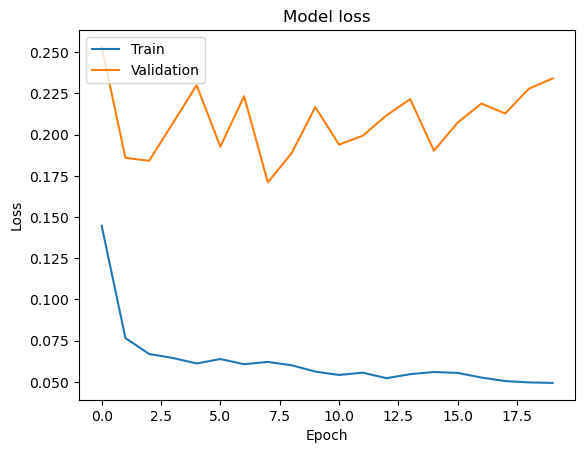

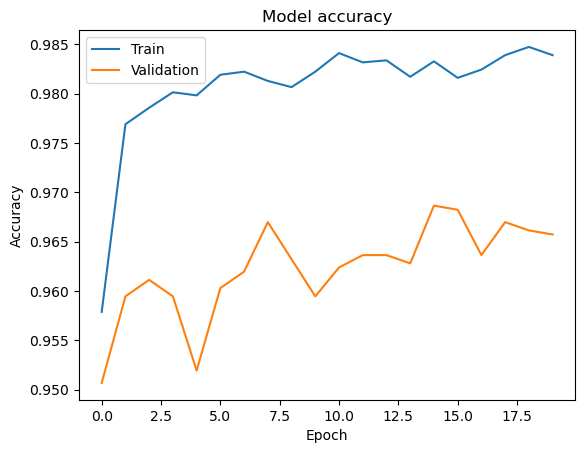

In [4]:
## Supervised Contrastive Learning with Shuffling 20 epochs


# Define constants
num_classes = 8
input_shape = (224, 224, 3)
learning_rate = 0.001
batch_size = 64
hidden_units = 512
projection_units = 128
num_epochs = 20
dropout_rate = 0.5
temperature = 0.05

# Load custom dataset
def load_custom_dataset(dataset_path):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    label_names.sort()
    for label, label_name in enumerate(label_names):
        image_folder = os.path.join(dataset_path, label_name)
        for image_name in os.listdir(image_folder):
            image_path = os.path.join(image_folder, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, input_shape[:2])
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'
x_data, y_data = load_custom_dataset(dataset_path)

# Split the dataset into training and testing sets with stratification
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=True, stratify=y_data, random_state=42)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.02),
])

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

# Define encoder model
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="blood_cells_encoder")
    return model

# Define classifier model
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="blood_cells_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

# Supervised contrastive loss function
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

# Add projection head to encoder
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="blood_cells_encoder_with_projection-head"
    )
    return model

# Use supervised contrastive learning
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
encoder_with_projection_head.summary()
history = encoder_with_projection_head.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

# Train the classifier with the frozen encoder
classifier = create_classifier(encoder, trainable=False)
history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

# Evaluate on the test set
test_loss, test_accuracy = classifier.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss}")


# Make predictions
y_pred = classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print confusion matrix and class-wise correct/incorrect predictions
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

class_labels = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
for i, label in enumerate(class_labels):
    correct_predictions = np.sum((y_pred_classes == y_test) & (y_test == i))
    incorrect_predictions = np.sum((y_pred_classes != y_test) & (y_test == i))
    print(f"Class: {label}, Correct Predictions: {correct_predictions}, Incorrect Predictions: {incorrect_predictions}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1_score}")


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "blood_cells_encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 blood_cells_encoder (Funct  (None, 2048)              23564807  
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23827079 (90.89 MB)
Trainable params: 23781632 (90.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________
Epoch 1/20
150/150 [==============================] - 1708s 11s/step - loss: 3.0555 - val_loss: 4.0328
Epoch 2/20
150/150 [==============================] - 1231s 8s/step - loss:

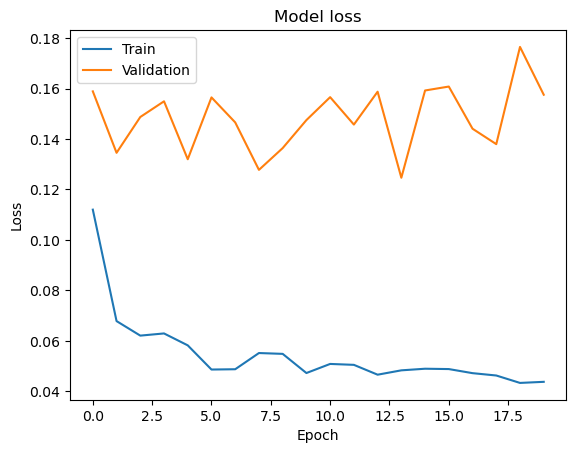

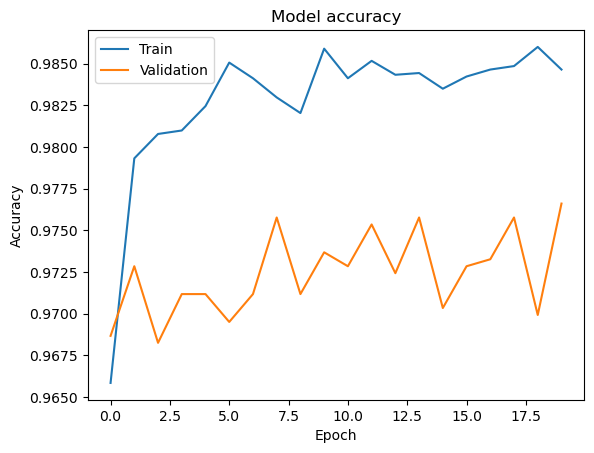

In [2]:
## Supervised Contrastive Learning without Shuffling



# Define constants
num_classes = 8
input_shape = (224, 224, 3)
learning_rate = 0.001
batch_size = 64
hidden_units = 512
projection_units = 128
num_epochs = 20
dropout_rate = 0.5
temperature = 0.05

# Load custom dataset
def load_custom_dataset(dataset_path):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    label_names.sort()
    for label, label_name in enumerate(label_names):
        image_folder = os.path.join(dataset_path, label_name)
        for image_name in os.listdir(image_folder):
            image_path = os.path.join(image_folder, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, input_shape[:2])
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load the dataset
dataset_path = 'C:\\Dataset_blood_cells\\bloodcells_dataset'
x_data, y_data = load_custom_dataset(dataset_path)

# Split the dataset into training and testing sets with stratification
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, stratify=y_data, random_state=42)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.02),
])

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

# Define encoder model
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="blood_cells_encoder")
    return model

# Define classifier model
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="blood_cells_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

# Supervised contrastive loss function
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

# Add projection head to encoder
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="blood_cells_encoder_with_projection-head"
    )
    return model

# Use supervised contrastive learning
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
encoder_with_projection_head.summary()
history = encoder_with_projection_head.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

# Train the classifier with the frozen encoder
classifier = create_classifier(encoder, trainable=False)
history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

# Evaluate on the test set
test_loss, test_accuracy = classifier.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss}")


# Make predictions
y_pred = classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print confusion matrix and class-wise correct/incorrect predictions
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

class_labels = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
for i, label in enumerate(class_labels):
    correct_predictions = np.sum((y_pred_classes == y_test) & (y_test == i))
    incorrect_predictions = np.sum((y_pred_classes != y_test) & (y_test == i))
    print(f"Class: {label}, Correct Predictions: {correct_predictions}, Incorrect Predictions: {incorrect_predictions}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1_score}")

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
